---
Author: Mustapha Bouhsen <br>
[LinkedIn](https://www.linkedin.com/in/mustapha-bouhsen/)<br>
[Git](https://github.com/mus514)<br>
Date: February 7, 2024<br>
---

In [0]:
%run Repos/mustapha.bouhsen@hec.ca/ML_Pipeline_Hub/library/garch_model

In [0]:
#-----------------------------------------
# load libraries
#-----------------------------------------
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DateType
from pyspark.sql import functions as F 
from pyspark.sql.functions import udf
import pandas as pd
import numpy as np
from datetime import datetime



### Create table from Azure storage for each stock


In [0]:
#-----------------------------------------
# Set the prod folder path
#-----------------------------------------
prod_folder_path = "/mnt/prod/"

stocks = ["aapl", "amzn", "googl", "msft"]

In [0]:
#-----------------------------------------
# Create the daily table for each stock
#-----------------------------------------
for stock in stocks:
    # Create the path for the stock
    path = f'{prod_folder_path}{stock}/year=*/month=*/*'
    # Load all the parquet files at once
    df = spark.read.parquet(path)
    
    # Check if the table exists
    if spark.catalog.tableExists(stock):
        # Drop the existing table
        spark.sql(f"DROP TABLE {stock}")
        print(f'Dropped table: {stock}')
    
    # Create the table
    df.write.format("parquet").saveAsTable(stock)
    print(f'Table for {stock} is created')

Dropped table: aapl
Table for aapl is created
Dropped table: amzn
Table for amzn is created
Dropped table: googl
Table for googl is created
Dropped table: msft
Table for msft is created


In [0]:
%sql

--- Display the table for apple stock
SELECT *
FROM aapl
LIMIT 10

date,open,high,low,close,adj_close,volume
2019-10-31,61.81,62.2925,59.315,62.19,60.32915,1.39162E8
2019-10-30,61.19,61.325,60.3025,60.815,58.995293,1.24522E8
2019-10-29,62.2425,62.4375,60.6425,60.8225,59.002563,1.428396E8
2019-10-28,61.855,62.3125,61.68,62.2625,60.399483,9.65728E7
2019-10-25,60.79,61.6825,60.72,61.645,59.800465,7.34772E7
2019-10-24,61.1275,61.2,60.4525,60.895,59.072906,6.92752E7
2019-10-23,60.525,60.81,60.305,60.795,58.97589,7.58288E7
2019-10-22,60.29,60.55,59.905,59.99,58.194984,8.22936E7
2019-10-21,59.38,60.2475,59.33,60.1275,58.328365,8.72472E7
2019-10-18,58.6475,59.395,58.5725,59.1025,57.33404,9.74336E7


In [0]:
%sql
-- Disply the year average stock price for aapl
SELECT year(date) as year, avg(close) as mean_stock_price_by_year
FROM aapl
GROUP BY year(date)
ORDER BY year(date)

year,mean_stock_price_by_year
2004,0.6344097272034676
2005,1.66700113056198
2006,2.528951308641776
2007,4.5812108640176845
2008,5.070679018148792
2009,5.24336163108311
2010,9.280087898647974
2011,13.000154476317148
2012,20.573204307556153
2013,16.87981717170231


## Creating table for stocks prices

In [0]:
%sql
DROP TABLE IF EXISTS stocks_prices;

CREATE TABLE stocks_prices AS
SELECT aapl.date, aapl.adj_close as aapl, amzn.adj_close as amzn, msft.adj_close as msft, googl.adj_close as googl
FROM aapl
JOIN amzn ON aapl.date = amzn.date
JOIN msft ON aapl.date = msft.date
JOIN googl ON aapl.date = googl.date
ORDER BY date;

num_affected_rows,num_inserted_rows


In [0]:
%sql
-- Disply the stock prices
SELECT *
FROM stocks_prices
ORDER BY date DESC
LIMIT 10

date,aapl,amzn,msft,googl
2024-02-09,188.85,174.45,420.55,149.0
2024-02-08,188.08002,169.84,414.11,145.91
2024-02-07,189.16862,170.53,414.05,145.54
2024-02-06,189.05876,169.15,405.49,144.1
2024-02-05,187.44081,170.31,405.65,143.68
2024-02-02,185.61316,171.81,411.22,142.38
2024-02-01,186.62187,159.28,403.78,141.16
2024-01-31,184.165,155.2,397.58,140.1
2024-01-30,187.80035,159.0,408.59,151.46
2024-01-29,191.48566,161.26,409.72,153.51


## Creating table containg the log return for each stock prices

The log return is given by :

$$
r_t = log(\frac{P_t}{P_{t-1}})
$$

Where $P_t$ is the stock price at time t

In [0]:
#-----------------------------------------
# Loading the stocks_prices table and calculate the log return for each stock
#-----------------------------------------
df = spark.sql("SELECT * FROM stocks_prices")

# Calculate the log return for each stock
for stock in stocks:
    # Order by date
    df = df.orderBy("date")
    # Create a window specification
    windowSpec = Window.orderBy("date")
    # Calculate log return
    col_expr = F.log(df[stock]) - F.lag(F.log(df[stock])).over(windowSpec)
    # Round the return
    col_expr_rounded = F.round(col_expr, 6)
    # Assign the new column to the dataframe
    df = df.withColumn(stock, col_expr_rounded)

# Delete The Null row
df = df.na.drop()

# Check if the table exists
if spark.catalog.tableExists("stocks_returns"):
    # Drop the existing table
    spark.sql(f"DROP TABLE stocks_returns")
    print(f'Dropped table: stocks_returns')


# Create the table
df.write.format("parquet").saveAsTable("stocks_returns")

Dropped table: stocks_returns


In [0]:
%sql
-- Disply the stocks_returns
SELECT *
FROM stocks_returns
ORDER BY date DESC
LIMIT 10

date,aapl,amzn,msft,googl
2024-02-09,0.004086,0.026782,0.015432,0.020957
2024-02-08,-0.005771,-0.004055,1.45E-4,0.002539
2024-02-07,5.81E-4,0.008125,0.020891,0.009943
2024-02-06,0.008595,-0.006835,-3.95E-4,0.002919
2024-02-05,0.009799,-0.008769,-0.013638,0.009089
2024-02-02,-0.00542,0.075726,0.018258,0.008605
2024-02-01,0.013252,0.025949,0.015474,0.007537
2024-01-31,-0.019547,-0.02419,-0.027316,-0.077965
2024-01-30,-0.019433,-0.014113,-0.002762,-0.013444
2024-01-29,-0.003592,0.013359,0.014232,0.008636


## Creating table containg the GARCH(1,1) volatility for each stock

The volatility is given by :

$$
\sigma_{t}^2= \omega+ \alpha y^2_{t-1} + \beta \sigma^2_{t-1} \ , \ \omega \ge 0 \ \ \ \  \alpha, \beta>0 \ and
 \ \alpha+ \beta<1
$$

## Load the data

In [0]:
returns = spark.sql("SELECT * FROM stocks_returns").toPandas()
prices = spark.sql("SELECT * FROM stocks_prices").toPandas()

In [0]:
#-----------------------------------------
# Calculate the GARCH(1,1) volatility for each stock
#-----------------------------------------
garch_vol = {}
garch_vol["date"] = returns["date"]
for stock in stocks:
    garch_vol[stock] = forecast_vol(returns[stock])[0][:-1]

garch_vol = pd.DataFrame(garch_vol)

<AxesSubplot:xlabel='date', ylabel='aapl'>

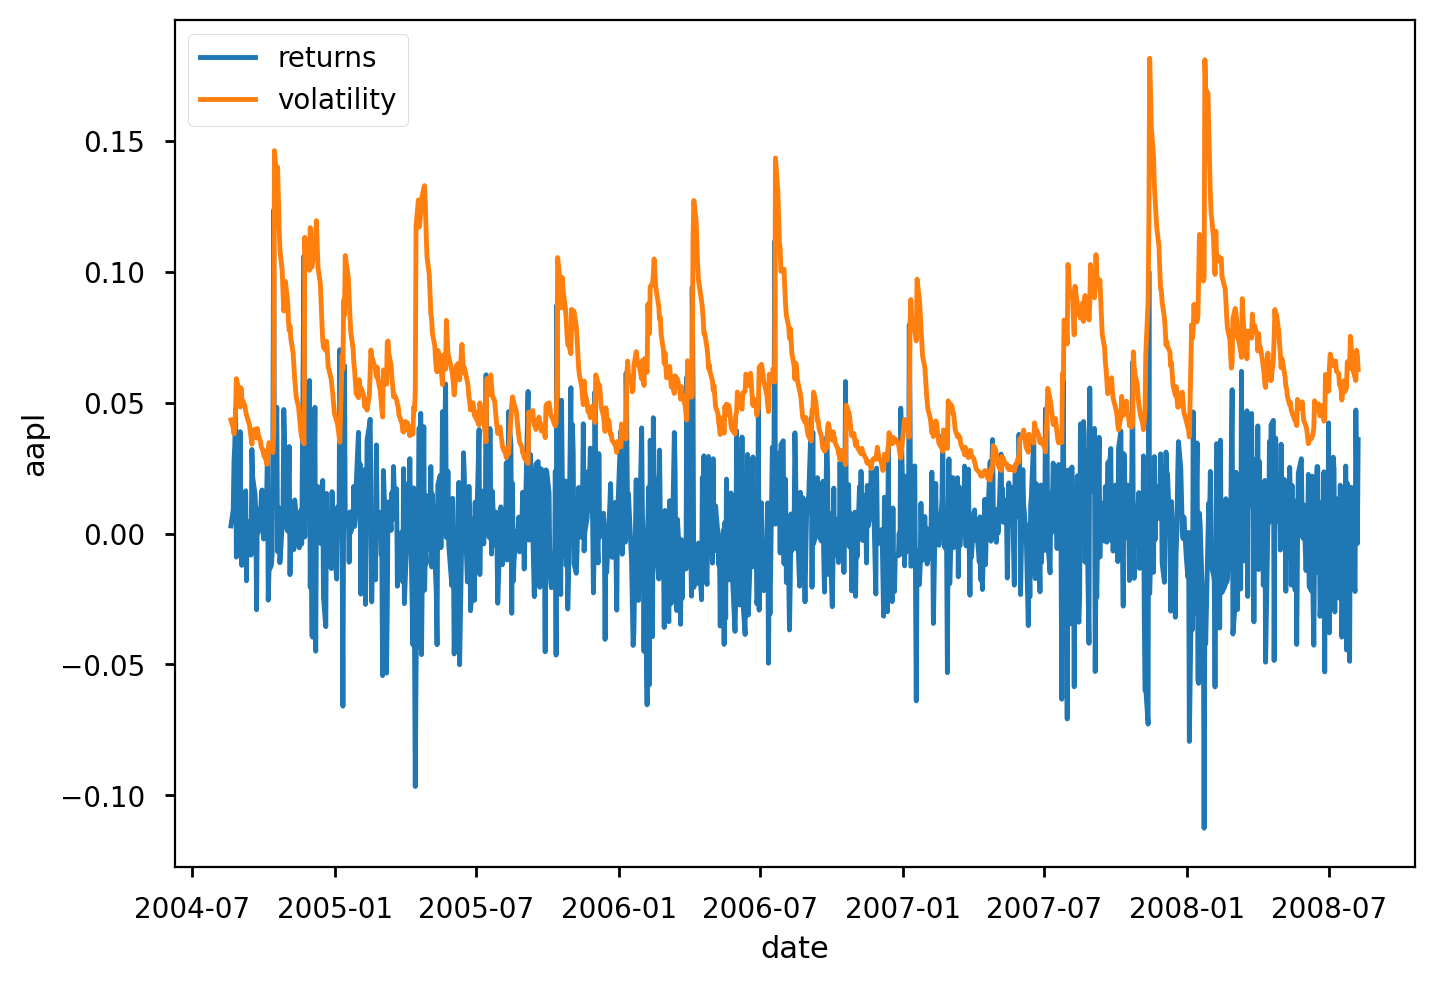

In [0]:
#-----------------------------------------
# Visualisation of returns and Garch volatility
#-----------------------------------------
sns.lineplot(y=returns["aapl"][0:1000], x=garch_vol["date"][0:1000], label="returns")
sns.lineplot(y=garch_vol["aapl"][0:1000]*100, x=garch_vol["date"][0:1000], label="volatility")

In [0]:
#--------------------------------------------------------
# Convert the data to spark to save it esaly to sql table
#--------------------------------------------------------
# Define the schema
schema = StructType([
    StructField("date", DateType(), True),
    StructField("aapl", FloatType(), True),
    StructField("amzn", FloatType(), True),
    StructField("msft", FloatType(), True),
    StructField("googl", FloatType(), True)
])

garch_vol = spark.createDataFrame(garch_vol, schema)

# Check if the table exists
if spark.catalog.tableExists("stocks_volatility"):
    # Drop the existing table
    spark.sql(f"DROP TABLE stocks_volatility")
    print(f'Dropped table: stocks_volatility')

# Create the table
garch_vol.write.format("parquet").saveAsTable("stocks_volatility")

Dropped table: stocks_volatility


In [0]:
%sql
-- Disply the stocks_returns
SELECT *
FROM stocks_volatility
ORDER BY date DESC
LIMIT 10

date,aapl,amzn,msft,googl
2024-02-09,1.9258074E-4,6.316822E-4,4.139998E-4,2.036668E-4
2024-02-08,2.0011331E-4,7.083885E-4,4.4714205E-4,2.2066543E-4
2024-02-07,2.1101211E-4,7.934762E-4,4.764977E-4,1.9710031E-4
2024-02-06,2.1717857E-4,8.977009E-4,5.164025E-4,2.1317218E-4
2024-02-05,2.222089E-4,0.0010182385,5.547502E-4,2.1319948E-4
2024-02-02,2.3302219E-4,4.1289165E-4,5.9804146E-4,1.9873533E-4
2024-02-01,2.3333589E-4,3.5995134E-4,6.4752495E-4,1.9149669E-4
2024-01-31,2.1732677E-4,3.0837656E-4,2.1631307E-4,1.3340688E-4
2024-01-30,2.0006506E-4,2.9787674E-4,2.1346295E-4,1.3988338E-4
2024-01-29,2.0996378E-4,2.880745E-4,2.1886798E-4,1.2808711E-4


## Simulation of the stock prince for the 10 next days using Monte-Carlo

In [0]:
schema = StructType([
    StructField("day_1", FloatType(), True),
    StructField("day_2", FloatType(), True),
    StructField("day_3", FloatType(), True),
    StructField("day_4", FloatType(), True),
    StructField("day_5", FloatType(), True),
    StructField("day_6", FloatType(), True),
    StructField("day_7", FloatType(), True),
    StructField("day_8", FloatType(), True),
    StructField("day_9", FloatType(), True),
    StructField("day_10", FloatType(), True),
])

In [0]:
#--------------------------------------------------------
# Simultation of the prices for the 10 next days
#--------------------------------------------------------

# Set the number of days for the Monte Carlo simulation and the number of simulations
days = 10
n_sim = 1000

# Iterate through each stock
for stock in stocks:
    # Extract historical returns for the current stock
    r = returns[stock]

    # Generate Monte Carlo simulations of future returns for the specified number of days and simulations
    simret = forecast_return(r, days, n_sim)

    # Get the last price of the stock
    last_price = list(prices[stock])[-1]

    # Calculate simulated prices using the cumulative sum of simulated returns
    price = last_price * np.exp(np.cumsum(simret, axis=1))

    # Convert simulated prices to a Spark DataFrame with the specified schema
    df = spark.createDataFrame(price, schema)

    # Define the table name for the Monte Carlo simulation results
    table_name = f'{stock}_monte_carlo'

    # Check if the table already exists in the Spark catalog
    if spark.catalog.tableExists(f"{table_name}"):
        # If the table exists, drop it
        spark.sql(f"DROP TABLE {table_name}")
        print(f'Dropped table: {table_name}')

    # Create a new table with the simulated prices
    df.write.format("parquet").saveAsTable(table_name)

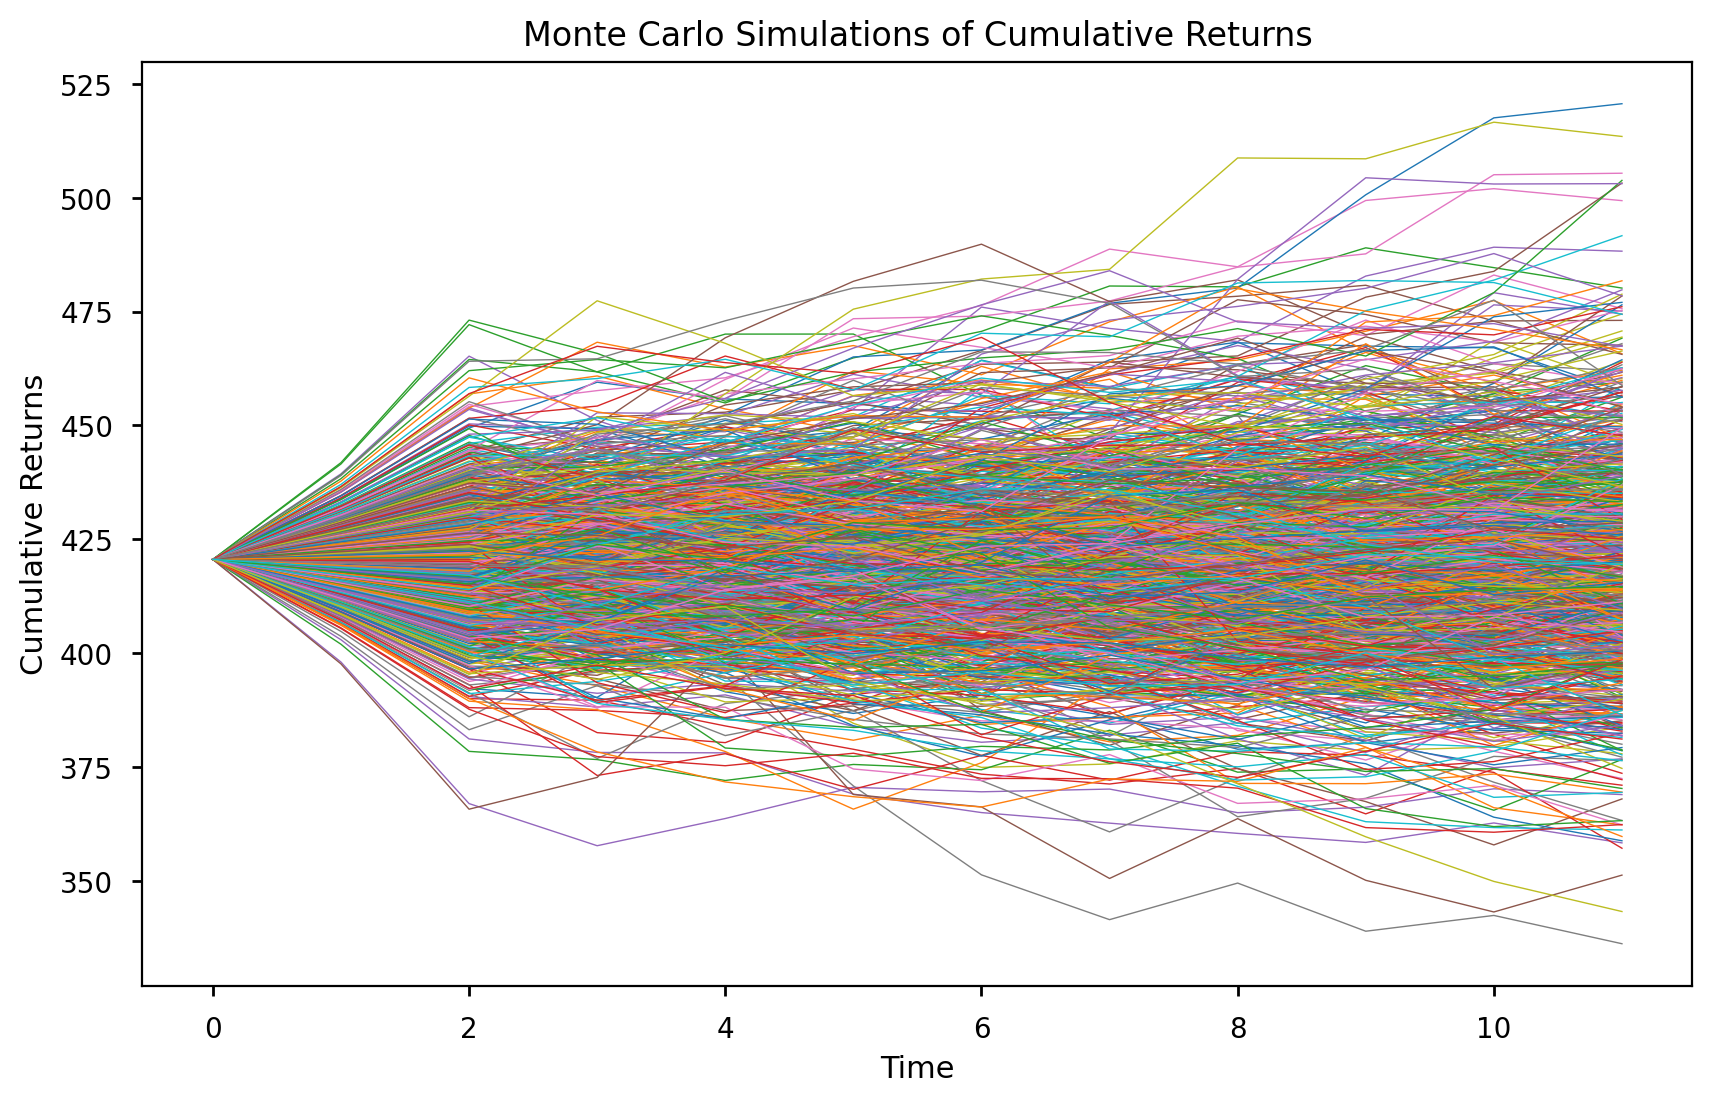

In [0]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(price.T, linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Monte Carlo Simulations of Cumulative Returns')
plt.show()